In [12]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import matplotlib.patches as patches

**Problem Formulation**
The primary objective of this study is to guide a vehicle to a designated parking spot while avoiding obstacles, which are represented as ellipses. The inputs for controlling the vehicle are generated by a neural network. It is crucial to emphasize that under no circumstances should the vehicle collide with any of the obstacles.

Throughout the trajectory, an error function is computed at each time step to ensure the vehicle's safe navigation. This error function serves as a critical feedback mechanism to make real-time adjustments to the vehicle's path, preventing any collisions with the obstacles.

The ultimate goal is to bring the vehicle to a state of zero velocity while meeting specific orientation requirements at the final parking position. This comprehensive approach not only addresses the avoidance of obstacles but also takes into account the precise alignment and stationary state of the vehicle at the conclusion of the maneuver.

I have simulated "Self Parking Car" using bicycle model dynamics. Many vehicle dynamics models exist with varying levels of complexity and accuracy. One commonly used and relatively simple model is referred to as the "bicycle model." Despite its name, the bicycle model is not intended for modeling bicycle handling dynamics. In reality, it would be an inadequate model for bicycle dynamics because it does not consider factors such as roll.

              x_dot = v * cos(ψ)
              y_dot = v * sin(ψ)
              ψ_dot = v * 𝛽 /L
              v_dot = a

I have used four variables in state space equation. x,y coordinates of robot with respect to world frame. ψ being the orientation of the car angle with respect to x-axis and v being the velocity of the car. The inputs to the system are steering angle and acceleration. In this model the car can only move forward, It can break and change the direction of steering wheel.

There are constraints on the state variables, v is the velocity which should be between 0 and 2. L = 0.5, and acceleration values lie between 0.5 and -0.5 and -0.5 means full break.


In [15]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):

        state_tensor = torch.zeros((1,4))
        v = state[0,2]
        A = torch.tensor([[1. , 0., torch.cos(state[0,3])*FRAME_TIME, 0.],
                          [0., 1., torch.sin(state[0,3])*FRAME_TIME, 0.],
                          [0., 0., 1., 0.],
                          [0., 0., 0., 1.]])

        theta_tensor= FRAME_TIME*torch.mul(torch.tensor([[0.,0.,0., 1.]]), v*action[0,1].reshape(-1,1)/L)
        v_tensor = ACCEL * torch.mul(torch.tensor([[ 0.5*torch.cos(state[0,3])*FRAME_TIME**2, 0.5*torch.sin(state[0,3])*FRAME_TIME**2, FRAME_TIME, 0.]]), action[0, 0].reshape(-1, 1))
        state = torch.matmul(A, state.T)
        state = state.T
        state = state + v_tensor + theta_tensor
        v = state[0,2].item()
        if v > v_max:
          v = v_max
        elif v< 0:
          v = 0
        state[0,2] =v
        return  state

The neural network controller was meticulously designed through a process involving reference research and observations of the results. Notably, significant enhancements were made to adapt the controller originally developed for a rocket lander.

One of the key modifications was the expansion of the hidden layers. Specifically, the dimensions of these layers were substantially increased to 10 and 20, enabling the neural network to capture more complex relationships within the data. This expansion facilitates the network's ability to learn and represent intricate patterns, which is especially valuable for controlling the vehicle's behavior effectively.

Additionally, the activation functions within the hidden layers were changed to Rectified Linear Units (ReLU). ReLU functions are known for their ability to introduce non-linearity into the model, allowing the neural network to model complex, non-linear dynamics more effectively.

Furthermore, the activation function for the output layer was strategically chosen as the hyperbolic tangent (tanh) function. This choice is particularly suitable for applications where the output needs to be bounded within a specific range, making it a valuable addition to the controller.

These modifications collectively enhance the neural network controller's performance and adaptability, making it better equipped to handle the complex control task originally designed for rocket landing.

In [16]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden*2),
            nn.ReLU(),
            nn.Linear(dim_hidden*2, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh())

    def forward(self, state):
        action = self.network(state)
         # bound theta_dot range -1 to 1
        return action


The error function has been meticulously crafted to ensure the vehicle's safe navigation throughout its trajectory. It is designed to prevent any collisions with obstacles at any point during the mission while guiding the vehicle to its final state.

This error function operates on a point model, meaning that it triggers an error only when the center of the car comes into contact with an obstacle. Substantial penalties are imposed in cases of collisions with obstacles to strongly discourage such occurrences and prioritize obstacle avoidance as a critical objective.

The overarching aim is to guide the vehicle to its ultimate destination, taking into account the specific requirements for the final state, while simultaneously enforcing strict avoidance of obstacles. This comprehensive approach not only emphasizes the importance of reaching the target state but also places a high priority on safety by minimizing the risk of collision with obstacles at all times.


In [17]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        loss =0
        for i in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
            loss += self.error(state, i, loss)
        return loss

    @staticmethod
    def initialize_state():
        state = ins
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state, t, loss):

        if(t==T-1):
          loss += torch.mean(((state-fs)*weight)**2)

        def cons1(state):
          x = state[0,0].item();
          y = state[0,1].item();
          x_c_1 = 9
          y_c_1 = 1
          a_1 = 0.5
          b_1 = 0.25
          constraint_value = 1-(((x - x_c_1)**2 / a_1**2) + ((y - y_c_1)**2 / b_1**2))
          return torch.max(torch.tensor([0.0, constraint_value]))

        def cons2(state):
          x = state[0,0].item();
          y = state[0,1].item();
          x_c_1 = 11
          y_c_1 = 1
          a_1 = 0.5
          b_1 = 0.25
          constraint_value = 1-(((x - x_c_1)**2 / a_1**2) + ((y - y_c_1)**2 / b_1**2))
          return torch.max(torch.tensor([0.0, constraint_value]))
        #print(cons2(state))
        loss += 10*cons1(state) +10*cons2(state)
        return loss

In [18]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr) # define the opmization algorithm
        self.loss_list = []
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model


    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            l[epoch]=loss
            self.visualize()
            if loss <=0.001:
                break


        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        #vy = data[:, 3]
        theta = data[:, 3]

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        a = action_data[:,0]
        sa = action_data[:,1]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 5, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        #ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, sa, c = 'y', label = "Steering angle")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("phi")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'SA plot at {self.epoch}')

        ax[4].plot(frame, a, c = 'y', label = "acceleration")
        ax[4].set_xlabel("Time interval")
        ax[4].set_ylabel("a")
        ax[4].legend(frameon=0)
        ax[4].set(title=f'a plot at {self.epoch}')

        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        #
        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,7)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'red') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'blue') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'yellow') # acceleration

        plt.tight_layout()

        ax1.set_xlim(mxl, xl)
        ax1.set_ylim(myl, yl)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 3]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.cos(rocket_theta), rocket_x - length/1 * np.cos(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.sin(rocket_theta), rocket_y - length/1 * np.sin(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.cos(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.sin(rocket_theta)]

            ellipse1 = patches.Ellipse((9, 1), 2 * 0.25, 2 * 0.5, fill=True, color='grey')
            ellipse2 = patches.Ellipse((11,1), 2*0.25, 2*0.5, fill=True, color='grey')

            ax1.add_patch(ellipse1)
            ax1.add_patch(ellipse2)
            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("parallel_car_parking.gif", writer=writer)




In [19]:
# environment parameters
FRAME_TIME = 0.1  # time interval
ACCEL = 0.5  # thrust constant
v_max =2
weight=torch.tensor([[1.,5.,1.,1.]])
fs = torch.tensor([[10.,1.,0.,-1.57]])
ins =[[2.,4.,0., 0.]]
L = 0.5
lr =0.001
mxl =-3
xl=13
myl=-1
yl=5

Throughout the training process, I encountered multiple minima when using a learning rate of 0.01. To navigate this challenge, I adopted a strategy of preserving checkpoint weights for potential trajectories. Subsequently, I fine-tuned one of these trajectories using a lower learning rate of 0.0001, ultimately achieving the lowest loss value of 0.06.

In addition to optimizing the learning rate, I undertook the task of fine-tuning other crucial parameters such as velocity limits (v limits), acceleration limits (a limits), and specific variables like L values. These adjustments were made based on insights gained from multiple training runs and observations, ensuring that the model's performance aligns with the desired outcome.

During the coding process in PyTorch, I faced the challenge of working with tensors for state equations. This required a deeper understanding of tensor operations and their nuances. While this presented some difficulties, I was able to overcome them by carefully reading and interpreting error messages and making necessary corrections. These efforts ultimately contributed to the successful achievement of the desired results.

[1] loss: 0.006


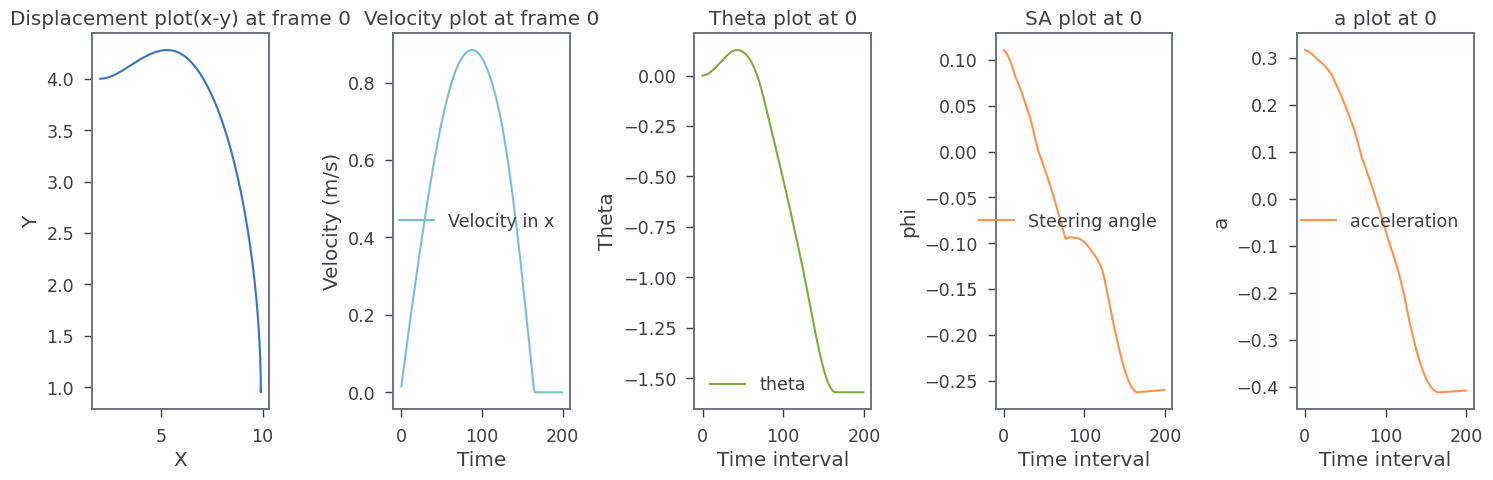

[2] loss: 0.006


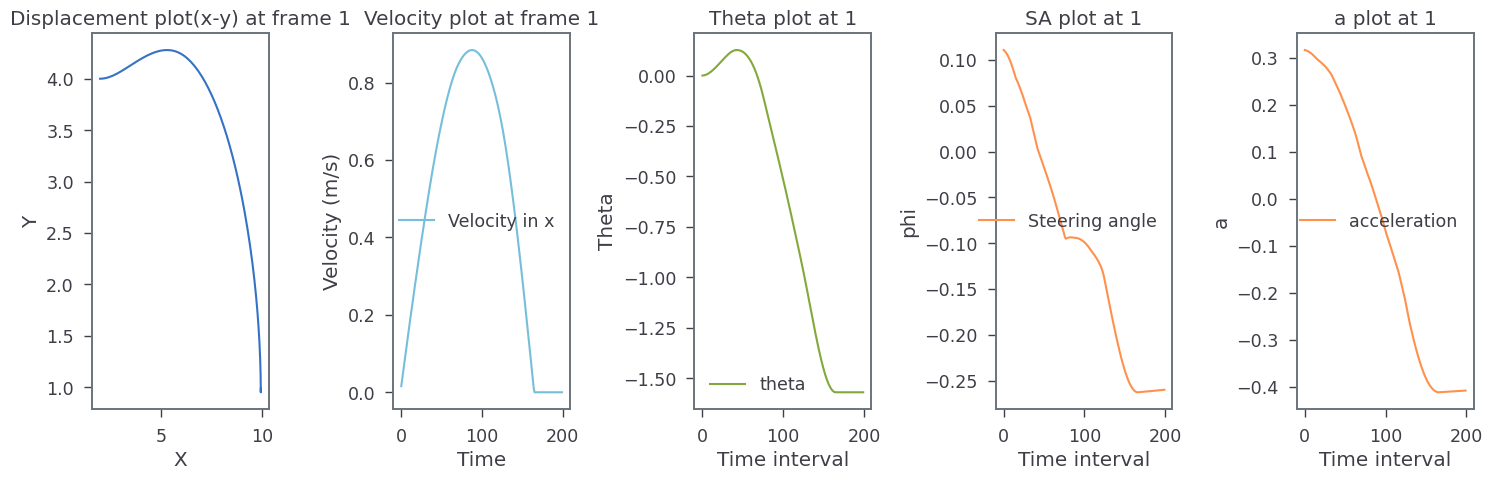

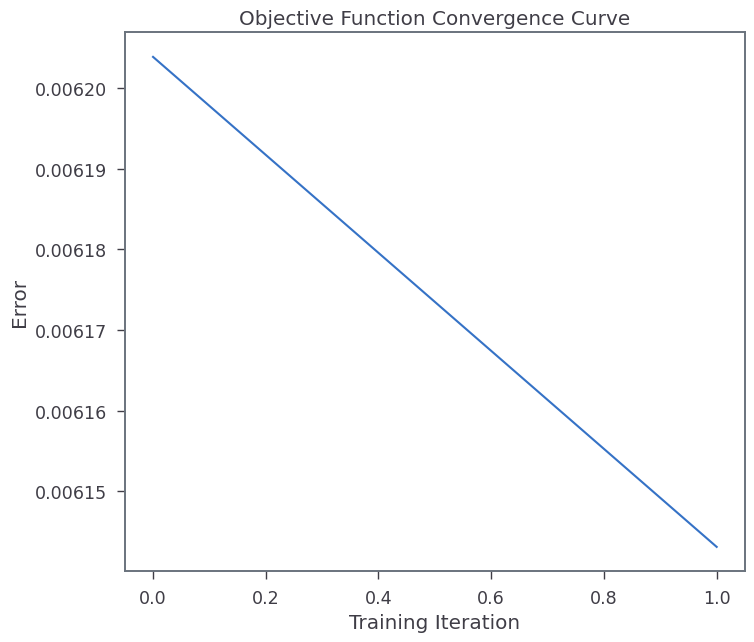

Generating Animation


IntProgress(value=0, max=201)

(200, 4) (200, 2)


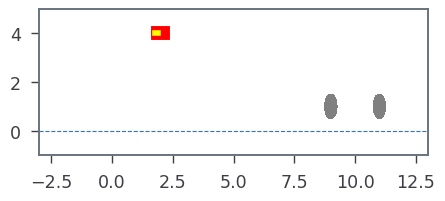

In [20]:
T = 200  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
checkpoint = torch.load('checkpoint4.pth')  # Replace 'X' with the desired epoch number
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
c.load_state_dict(checkpoint['model_state_dict'])
o.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

o.train(2)  # training with number of epochs (gradient descent steps)

In [21]:
checkpoint = {
    'model_state_dict': c.state_dict(),
    'optimizer_state_dict': o.optimizer.state_dict(),
    'epoch': 50,
    # Add any other necessary information
}
torch.save(checkpoint, 'checkpoint4.pth')
